In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import re
from scipy.stats import fisher_exact
import math
import os

In [2]:
import pandas as pd
from IPython.display import Image
import os

In [5]:
import stathelper  

In [6]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
import warnings

# Ignore specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning)


##  <font color = 'Orange'> **Variables** </font>

In [7]:
features = ['TotalEnergy',
            'LessTotalEnergy',
            'VanDerWaalsClashes',
            #'Disulfide',
            'Contacts',
            'Conserved',
            #'Catalytic',
     
            'Core (<5%)',
            'Buried (5-25%)',
            'Medium-buried (25-50%)',
            'Medium-exposed (50-75%)',
            'Exposed (>75%)',

            'DisorderpLDDT',
            'OrderpLDDT',
            'helices',
            'β-sheet/starnd',
            'coils',
            'α-helix',
            'βbridge',
            'strandβladder',
            '310helix',
            'π-helix',
            'HBondTurn',
            'Bend',
            'Loop',
            'Small to Big',
            'Big to Small',
            'Polar to NonPolar',
            'NonPolar to Polar',
            'Hydrophilic introduced',
            'Hydrophobic introduced',
            'Charge switch',
            'Charge lost',
            'Charge gain',
            'Aromatic to NonAromatic',
            'Aromatic to polar',
]


In [8]:
len(features)

34

# **1. Load data**

In [9]:
concatenated_df_physico = pd.read_pickle('../results/2_features_all.pkl')
clinvar_gnomad_class_filt = pd.read_csv('../results/3_features_byprotienclass.csv')
clinvar_gnomad_class_filt_both = pd.read_csv('../results/4_features_geneboth.csv')

/var/folders/n3/2fl50g550vl4n3zpn4cwfhq4mc9tcm/T/ipykernel_56157/2805292310.py:2: DtypeWarning: Columns (0,2,9,10,11,12,13,14,15,17,18,19,20,22,50,65,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_gnomad_class_filt = pd.read_csv('../results/3_features_byprotienclass.csv')
/var/folders/n3/2fl50g550vl4n3zpn4cwfhq4mc9tcm/T/ipykernel_56157/2805292310.py:3: DtypeWarning: Columns (1,3,10,11,12,13,14,15,16,18,19,20,21,23,51,66,106,107,108,109,110,111,112,113,114,115,116) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_gnomad_class_filt_both = pd.read_csv('../results/4_features_geneboth.csv')


# **2. Equal amount of variants per protein class**

In [10]:

classes_more_pat = ['C1_DNA_metabolism_protein',
 'C2_RNA_metabolism_protein',
 'C4_cell_adhesion_molecule',
 'C5_cell_junction_protein',
 'C6_chaperone',
 'C7_chromatin_binding_regulatory_protein',
 'C8_cytoskeletal_protein',
 'C10_extracellular_matrix_protein',
 'C11_gene_specific_transcriptional_regulator',
 'C12_intercellular_signal_molecule',
 'C14.1_hydrolase',
 'C14.2_isomerase',
 'C14.4_lyase',
 'C14.5_oxidoreductase',
 'C14.6_transferase',
 'C15_protein_modifying_enzyme',
 'C16_protein_binding_activity_modulator',
 'C20_transfer_carrier_protein',
 'C21_translational_protein',
 'C22_transmembrane_signal_receptor',
 'C23_transporter']

classes_more_ben = ['C17_scaffold_adaptor', 'C9_defense_immunity_protein',
                    'C13_membrane_traffic_protein', 'C19_structural_protein',
                     'C3_calcium_binding_protein']


common_elements = ['C1_DNA_metabolism_protein',
 'C2_RNA_metabolism_protein',
 'C3_calcium_binding_protein',
 'C4_cell_adhesion_molecule',
 'C5_cell_junction_protein',
 'C6_chaperone',
 'C7_chromatin_binding_regulatory_protein',
 'C8_cytoskeletal_protein',
 'C9_defense_immunity_protein',
 'C10_extracellular_matrix_protein',
 'C11_gene_specific_transcriptional_regulator',
 'C12_intercellular_signal_molecule',
 'C13_membrane_traffic_protein',
 'C14.1_hydrolase',
 'C14.2_isomerase',
 'C14.4_lyase',
 'C14.5_oxidoreductase',
 'C14.6_transferase',
 'C15_protein_modifying_enzyme',
 'C16_protein_binding_activity_modulator',
 'C17_scaffold_adaptor',
 'C18_storage_protein',
 'C19_structural_protein',
 'C20_transfer_carrier_protein',
 'C21_translational_protein',
 'C22_transmembrane_signal_receptor',
 'C23_transporter']

## From pathogenic variants select the ones with the disease of interest
newdf = pd.DataFrame()
df = clinvar_gnomad_class_filt 

for c in common_elements:
    wkg_df = df[df.GeneralProteinClass == c]
    pat_var = wkg_df[wkg_df.Source == 'Pathogenic']
    ben_var = wkg_df[wkg_df.Source == 'Common']
    nvarben = len(ben_var)
    nvarpat = len(pat_var)
    random_seed = 42

    if c in classes_more_pat:
        subset_pat_var = pat_var.sample(n=nvarben, random_state=random_seed) ## select only the amount of benvariants
        newdf = pd.concat([newdf, subset_pat_var], ignore_index=True)
        newdf = pd.concat([newdf, ben_var], ignore_index=True) ##full ben variants

    elif c in classes_more_ben:
        subset_ben_var = ben_var.sample(n=nvarpat, random_state=random_seed) ## select only the amount of patvariants
        newdf = pd.concat([newdf, subset_ben_var], ignore_index=True)
        newdf = pd.concat([newdf, pat_var], ignore_index=True) ##full pat variants



In [11]:
newdf.Source.value_counts()

Source
Pathogenic    10066
Common        10066
Name: count, dtype: int64

# **3. ODS all pat against all ben**

In [12]:
concatenated_df_physico.Source.value_counts()

Source
Pathogenic    31252
Common        15941
Pavs            481
Name: count, dtype: int64

In [13]:
#sum_results = stathelper.calculate_ODS_mult(features, newdf)
sum_results = stathelper.calculate_ODS_mult(features, newdf)

In [14]:
sum_results

,OR,p-value,q-value,CIL,CIU,pat_feat,pat_nofeat,ben_feat,ben_nofeat,significant?,ORs_clasification
TotalEnergy,13.903119,0.000000e+00,0.000000e+00,12.476386,15.493006,3658.0,6408.0,397.0,9669.0,significant,pathogenic
LessTotalEnergy,0.318165,1.318562e-283,4.483111e-282,0.298343,0.339305,1833.0,8233.0,4144.0,5922.0,significant,benign
VanDerWaalsClashes,2.993127,2.642514e-317,8.984548e-316,2.825942,3.170203,6066.0,4000.0,3385.0,6681.0,significant,pathogenic
Contacts,5.727395,0.000000e+00,0.000000e+00,5.330164,6.154230,8859.0,1207.0,5654.0,4412.0,significant,pathogenic
Conserved,15.514733,0.000000e+00,0.000000e+00,14.454659,16.652551,7267.0,2799.0,1443.0,8623.0,significant,pathogenic
...,...,...,...,...,...,...,...,...,...,...,...
Charge switch,1.382638,5.906969e-05,2.008369e-03,1.181202,1.618425,379.0,9687.0,277.0,9789.0,significant,pathogenic
Charge lost,1.384082,1.853211e-18,6.300917e-17,1.286912,1.488590,2028.0,8038.0,1552.0,8514.0,significant,pathogenic
Charge gain,1.752252,1.681235e-49,5.716197e-48,1.625510,1.888875,2114.0,7952.0,1326.0,8740.0,significant,pathogenic
Aromatic to NonAromatic,2.055480,6.014502e-33,2.044931e-31,1.821241,2.319846,825.0,9241.0,419.0,9647.0,significant,pathogenic


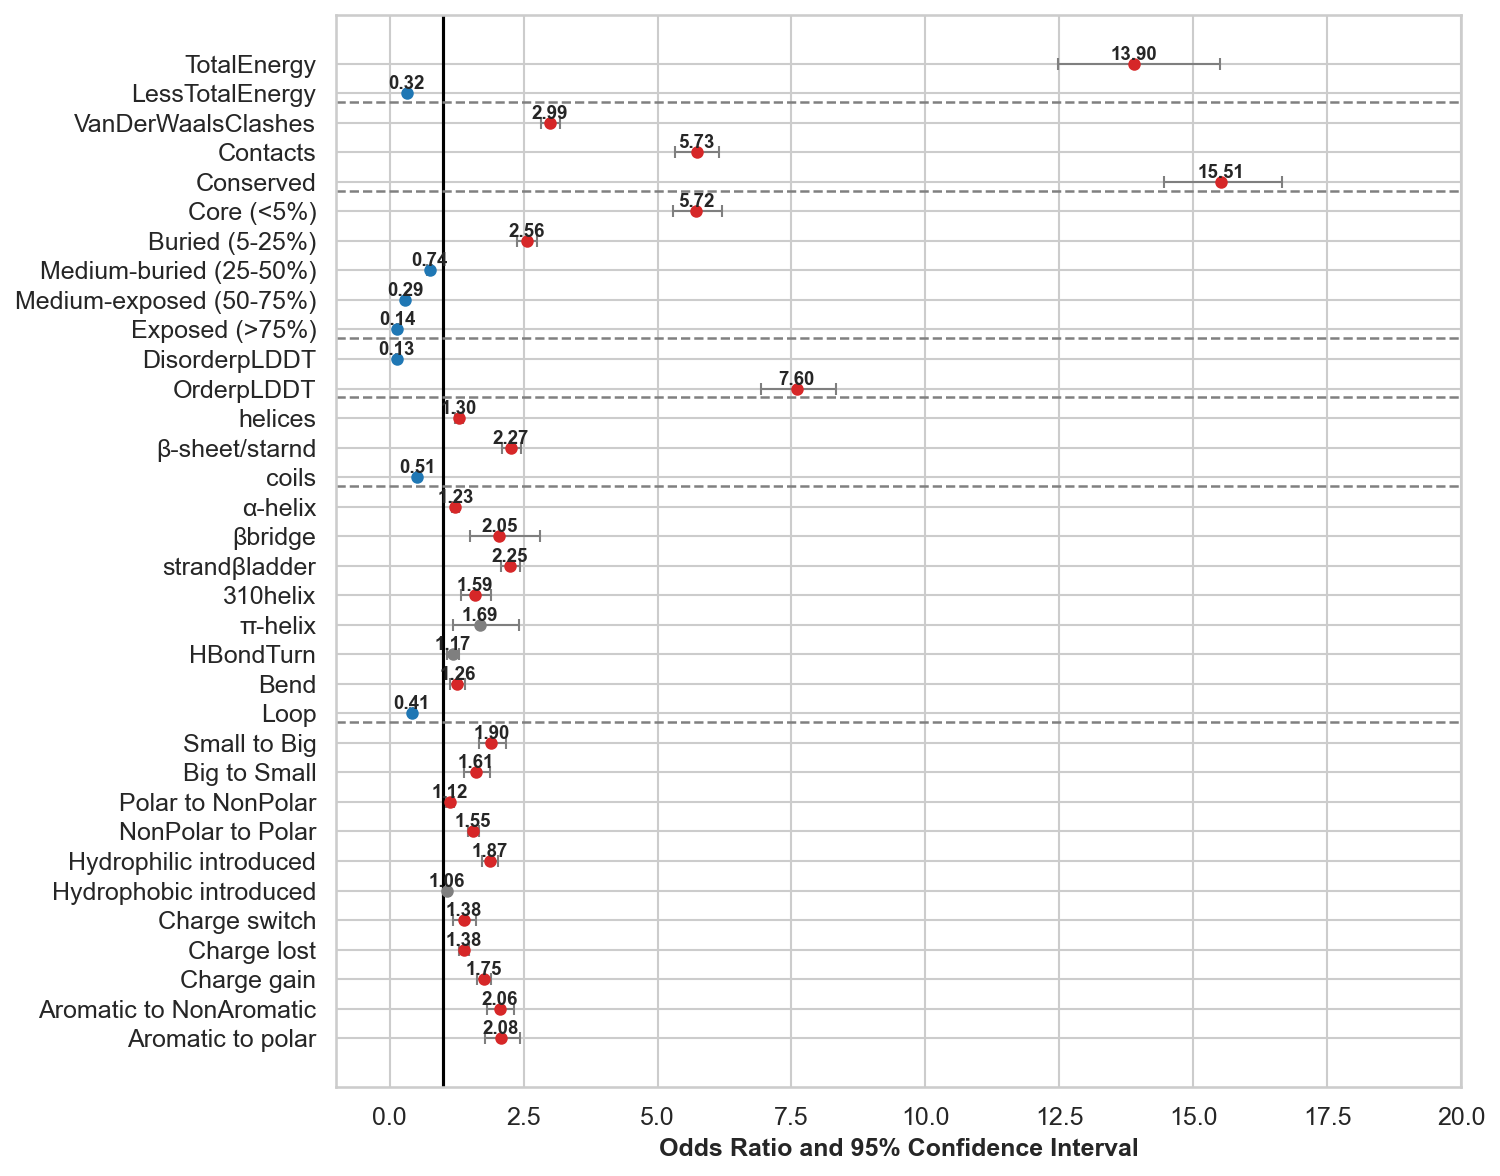

In [15]:
stathelper.plot_ODS(sum_results)

## **4. ODS by Protein Class**

In [19]:

common_elements = ['C1_DNA_metabolism_protein',
 'C2_RNA_metabolism_protein',
 #'C3_calcium_binding_protein',
 'C4_cell_adhesion_molecule',
 #'C5_cell_junction_protein',
 'C6_chaperone',
 'C7_chromatin_binding_regulatory_protein',
 'C8_cytoskeletal_protein',
 #'C9_defense_immunity_protein',
 'C10_extracellular_matrix_protein',
 'C11_gene_specific_transcriptional_regulator',
 'C12_intercellular_signal_molecule',
 'C13_membrane_traffic_protein',
 'C14.1_hydrolase',
 #'C14.2_isomerase',
 #'C14.4_lyase',
 'C14.5_oxidoreductase',
 'C14.6_transferase',
 'C15_protein_modifying_enzyme',
 'C16_protein_binding_activity_modulator',
 'C17_scaffold_adaptor',
 #'C18_storage_protein',
 'C19_structural_protein',
 'C20_transfer_carrier_protein',
 'C21_translational_protein',
 'C22_transmembrane_signal_receptor',
 'C23_transporter']

features = ['Stabilizing Energy Change',
            'Destabilizing Energy Change (<1 kcal/mol)',
            'Destabilizing Energy Change (1-3 kcal/mol)',
            'Destabilizing Energy Change (>3 kcal/mol)',

            #'LessTotalEnergy',
            'VanDerWaalsClashes',
            #'Disulfide',
            'Contacts',
            'No Contacts',
           

            'Conserved',
           
            #'Catalytic',
            'DisorderpLDDT',
            'OrderpLDDT',
            'Core (<5%)',
            'Buried (5-25%)',
            'Medium-buried (25-50%)',
            'Medium-exposed (50-75%)',
            'Exposed (>75%)',
            'helices',
            'β-sheet/starnd',
            'coils',
            'α-helix',
            #βbridge',
            'strandβladder',
            #'310helix',
            #'π-helix',
            #'HBondTurn',
            #'Bend',
            'Loop',
            'Small to Big',
            'Big to Small',
            'Polar to NonPolar',
            'NonPolar to Polar',
            'Hydrophilic introduced',
            #'Hydrophobic introduced',
            'Charge switch',
            'Charge lost',
            'Charge gain',
            'Aromatic to NonAromatic',
            'Aromatic to polar'
]



In [20]:
groupbyName = 'GeneralProteinClass'
feature_list = features
df = newdf
results = stathelper.calculate_ODS_multiple_grouped_by(common_elements, groupbyName, feature_list, df)


<Axes: >

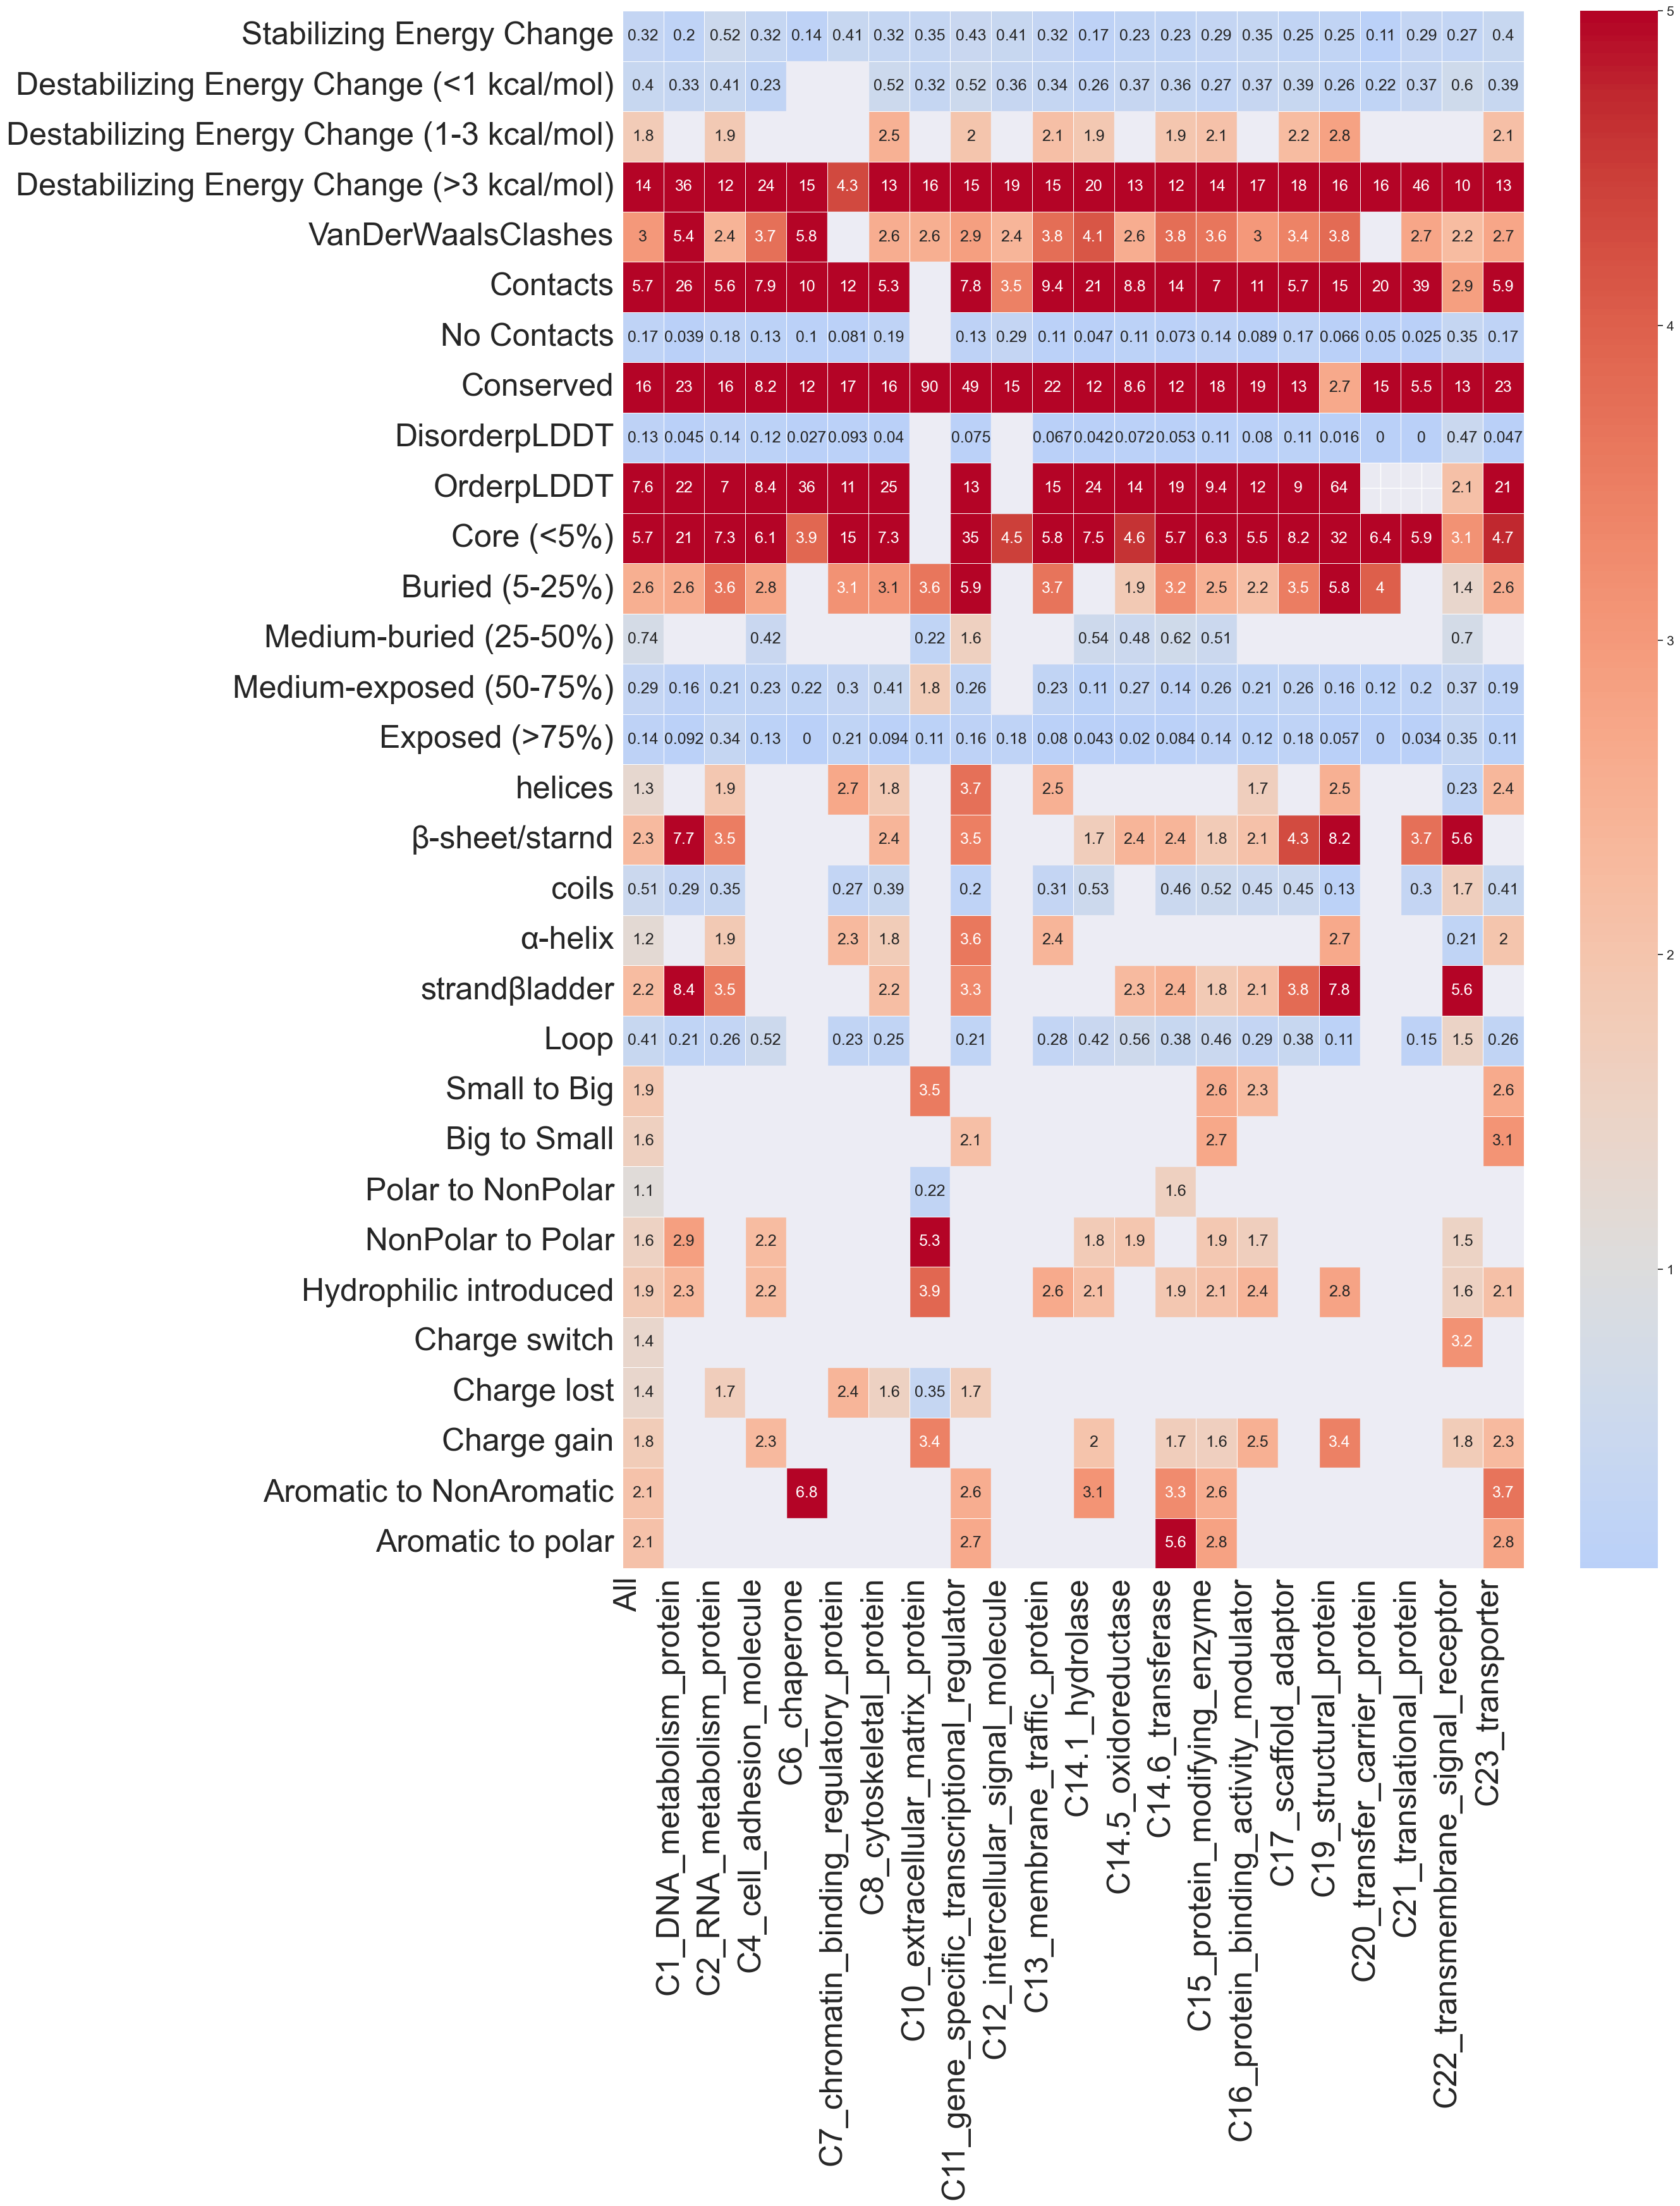

In [21]:

test_features_groupby = results
test_features_groupby = test_features_groupby.dropna(subset=['groupby'])
list_with_formated_names = features


list_order = common_elements
list_order = np.insert(list_order, 0, 'All')
    
stathelper.plot_heatmap(test_features_groupby, list_with_formated_names, list_order)